### LIBRARIES

In [2]:
# !pip install gymnasium
# !pip install numpy
# !pip install torch
# !pip install keras

In [3]:
import gymnasium as gym
import numpy as np
import random as rand
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from collections import deque
import matplotlib.pyplot as plt

### HYPERPARAMETERS

In [4]:
# Hyperparameters
GAMMA = 0.99  # Discount factor

# !!! (Test value, should be changed to 100-500. -Diego)
NUM_EPISODES = 5  # Number of episodes to run

BATCH_SIZE = 64  # Number of experiences to sample per training step
MEMORY_SIZE = 10000  # Experience replay memory size

LEARNING_RATE = 0.001  # Learning rate
EPSILON = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Exploration decay rate per episode
MIN_EPSILON = 0.01  # Minimum exploration rate

MAX_ITERATIONS = 500  # Max steps per episode
TARGET_UPDATE_FREQUENCY = 10  # Episodes between target network updates

### MEMORY

In [5]:
class Memory:
    """
    Experience Replay Memory.
    
    Args:
        max_memory (int): Maximum number of experiences the Memory can keep.
    """
    def __init__(self, max_memory):
        self._samples = deque(maxlen=max_memory)

    def add_sample(self, sample):
        self._samples.append(sample)

    def sample(self, num_samples):
        num_samples = min(num_samples, len(self._samples))
        return rand.sample(self._samples, num_samples)

    @property
    def num_samples(self):
        return len(self._samples)

### DEEP Q-LEARNING AGENT

In [6]:
class DQLAgent:
    """
    Deep Q-Learning Agent.
    """
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size

        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_min = MIN_EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.learning_rate = LEARNING_RATE
        self.batch_size = BATCH_SIZE

        self.memory = Memory(MEMORY_SIZE)

        # Main model (Q-network) and target model (target Q-network)
        self.main_model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Creates a neural network model.
        
        Returns:
            keras.models.Sequential: Neural network model.
        """
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """
        Updates the target Q-network with the weights of the main Q-network.
        """
        self.target_model.set_weights(self.main_model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Stores an experience in the replay memory.
        """
        self.memory.add_sample((state, action, reward, next_state, done))

    def act(self, state):
        """
        Selects an action using the epsilon-greedy policy.
        
        Args:
            state (array): Current state.
            
        Returns:
            int: Selected action.
        """
        if np.random.rand() <= self.epsilon:
            return rand.randrange(self.action_size)
        q_values = self.main_model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """
        Trains the Q-network using a batch of experiences from the replay memory.
        """
        if self.memory.num_samples < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states = np.array([sample[0] for sample in batch])
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_states = np.array([sample[3] for sample in batch])
        dones = np.array([sample[4] for sample in batch])
        
        # Target Q-values prediction
        next_qs = self.target_model.predict(next_states, verbose=0)
        max_next_qs = np.max(next_qs, axis=1)
        target_qs = rewards + (1 - dones) * self.gamma * max_next_qs

        # Actual Q-values prediction
        current_qs = self.main_model.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_qs[i][action] = target_qs[i]

        # Q-network training
        self.main_model.fit(states, current_qs, epochs=1, verbose=0)

    def load(self, name):
        """
        Loads a model from a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model = load_model(name)
        self.target_model = load_model(name)

    def save(self, name):
        """
        Saves the model to a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model.save(name)

In [26]:
def train_agent(env, agent):
    """
    Trains the agent using Deep Q-Learning.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        
    Returns:
        DQLAgent: Trained agent.
    """
    episode_rewards = []

    for episode in range(NUM_EPISODES):
        state, _ = env.reset()
        total_reward = 0

        for t in range(MAX_ITERATIONS):
            # Render environment
            # env.render()

            # Action selection
            action = agent.act(state)

            # Environment interaction
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            # Store experience in replay memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            # Experience replay
            agent.replay()

            if done or truncated:
                print(f"Episodio {episode + 1}/{NUM_EPISODES}, Recompensa Total: {total_reward}, Epsilon: {agent.epsilon:.2f}")
                break

        episode_rewards.append(total_reward)
        
        # Target model update
        if (episode + 1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_model()

        # Exploration rate decay
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
    
    # Graph total rewards per episode
    plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
    plt.title('Recompensa Total por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total')
    plt.xticks(range(1, NUM_EPISODES + 1))
    y_max = max(episode_rewards) * 1.1
    plt.ylim(0, y_max)
    plt.show()

def test_agent(env, agent, episodes=5):
    """
    Tests the agent in the environment.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        episodes (int): Number of episodes to run.
    """
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            env.render()
            q_values = agent.main_model.predict(np.array([state]), verbose=0)
            action = np.argmax(q_values[0])
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                total_rewards.append(total_reward)
                print(f"Prueba Episodio {episode + 1}/{episodes}, Recompensa Total: {total_reward}")
                break
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa promedio en {episodes} pruebas: {avg_reward}")
    env.close()


Episodio 1/5, Recompensa Total: 24.0, Epsilon: 1.00
Episodio 2/5, Recompensa Total: 30.0, Epsilon: 0.99
Episodio 3/5, Recompensa Total: 50.0, Epsilon: 0.99
Episodio 4/5, Recompensa Total: 12.0, Epsilon: 0.99
Episodio 5/5, Recompensa Total: 22.0, Epsilon: 0.98


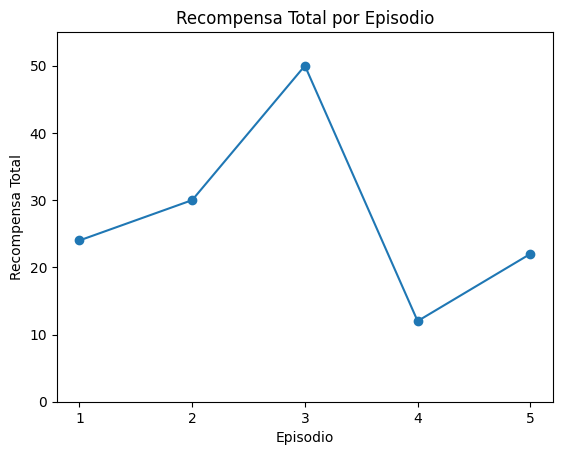

Prueba Episodio 1/5, Recompensa Total: 15.0
Prueba Episodio 2/5, Recompensa Total: 82.0
Prueba Episodio 3/5, Recompensa Total: 86.0
Prueba Episodio 4/5, Recompensa Total: 83.0
Prueba Episodio 5/5, Recompensa Total: 111.0
Recompensa promedio en 5 pruebas: 75.4


In [28]:
if __name__ == "__main__":
    # Environment
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Agent
    agent = DQLAgent(state_size, action_size)

    # Train agent
    train_agent(env, agent)

    # Save agent
    # agent.save("cartpole-dql.h5")

    # Test agent
    test_agent(env, agent)

    env.close()